# Monthly mean climatology @Dome Fuji

In [1]:
expname="jra25.gndg_fixsatuorg" ; intyr=30

In [2]:
import warnings
warnings.simplefilter("ignore")
from scipy import stats
import numpy as np
import pandas as pd
#
import matplotlib
import matplotlib.pyplot as plt
#
import seaborn as sns

In [3]:
# 描画設定
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.family': 'sans-serif', 'text.usetex': False,'pcolor.shading':'auto'})

In [4]:
class Site:
    def DomeF(self):
        sx=14 ; sy=60 # 77°18′59″S 39°42′04″E
        df_lat=-77.3
        df_lon=39.66
        return df_lon,df_lat,sx,sy

In [5]:
def Mon():
    import pandas as pd
    mons = pd.DataFrame({
            "": ["Jan", "Feb", "Mar","Apr","May","Jun",
                     "Jul","Aug","Sep","Oct","Nov","Dec","Jan"],
            })
    return mons
mons=Mon()

In [6]:
df_lon,df_lat,df_x,df_y = Site().DomeF()

In [7]:
def mon_ave(varin, var1,var2, var3,intyr):
    df_out = pd.DataFrame.from_dict({
        "temp":np.zeros(12),
        "tempw":np.zeros(12),
        "d18Op":np.zeros(12),
        "d18Opw":np.zeros(12),
        "prcp":np.zeros(12)
    }, orient="columns")
    df_out.index = mons[""][:12]
    
    for mm in range(12):
        df                              = varin[varin["Mon"]==mm+1]   
        df_out["temp"   ][mm] = np.nanmean(df[var1])
        df_out["tempw"][mm] = np.nanmean(df[var1]*df[var3])/np.nanmean(df[var3])
        df_out["d18Op"][mm] = np.nanmean(df[var2])
        df_out["d18Opw"][mm] = np.nanmean(df[var2]*df[var3])/np.nanmean(df[var3])
        df_out["prcp"][mm]  = np.sum(df[var3])/intyr
    df_out["Mon"] = np.arange(1,13,1)
    return df_out.T

In [8]:
loadfile = "T2.npz"
dataset = np.load(loadfile)
T2_raw        = dataset["T2"] 
lon2     = dataset["lon2"]
lat2     = dataset["lat2"]
y        = dataset["y"]
m        = dataset["m"]
d        = dataset["d"]

In [9]:
loadfile        = "prcp.npz"
dataset       = np.load(loadfile)
prcp_raw = dataset["prcp"]

In [10]:
loadfile        = "prcp_d18O.npz"
dataset       = np.load(loadfile)
prcp_d18O_raw = dataset["prcp_d18O"]

In [11]:
def reg_t_d18O(df_in, var1, var2):
    import statsmodels.api as sm
    import statsmodels.tools.eval_measures as smte
    t               = sm.add_constant(df_in[var1], prepend=False)
    t_d18Op    = sm.OLS(df_in[var2],t)
    res=t_d18Op.fit()
    r_t_d18Op = t_d18Op.fit()
    p_t_d18Op = np.poly1d(r_t_d18Op.params)
    
    text  = "a = {:4.2f} ± {:4.3f}".format(r_t_d18Op.params[0], r_t_d18Op.bse[0]) + "\n$r^2$" + " = {:4.3f}".format(r_t_d18Op.rsquared)
    alpha=r_t_d18Op.params[0]
    alpha_err=r_t_d18Op.bse[0]
    beta=r_t_d18Op.params[1]    
    beta_err=r_t_d18Op.bse[1]
    
    return text, p_t_d18Op,alpha,alpha_err, beta,beta_err,res

In [12]:
df_raw = pd.DataFrame.from_dict({
    "Number": np.zeros((np.shape(prcp_d18O_raw)[2])),
    "Year": y,
    "Mon" : m,
    "Date": d,
    "d18O": prcp_d18O_raw[df_x-1, df_y-1,:],
    "temp": T2_raw  [df_x-1, df_y-1, :]     ,
    "prcp": prcp_raw[df_x-1, df_y-1, :]    
},orient="columns" )

df_raw2=df_raw.dropna(how="any")

text_hist  , p_t_d18Op_hist,alpha,alpha_err,beta,beta_err,res   = reg_t_d18O(df_raw2,"d18O","temp")

#df_raw["d18O"]=df_raw["d18O"]*alpha+beta

In [13]:
df = mon_ave(df_raw, "temp","d18O","prcp",intyr).T
df.T

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
temp,-24.391404,-36.959155,-50.939015,-58.390352,-60.289275,-59.324765,-61.425745,-62.450692,-60.237975,-49.179207,-35.116882,-23.934653
tempw,-22.152851,-32.205265,-46.535406,-51.219188,-53.052320,-49.626341,-52.977960,-55.709548,-54.240160,-40.392978,-30.484352,-21.678944
d18Op,-30.410746,-52.221298,-70.589191,-75.423130,-79.440051,-79.687045,-83.234645,-85.865113,-86.704293,-75.971038,-47.090393,-31.689099
d18Opw,-34.689476,-52.091528,-63.921941,-66.441827,-69.747822,-68.113975,-73.108097,-77.140616,-79.759533,-66.229406,-50.486423,-35.826275
prcp,4.791862,2.422345,1.814004,2.225644,2.035098,2.578318,2.374815,1.610695,1.392202,2.012407,2.431147,6.047123
Mon,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000,12.000000


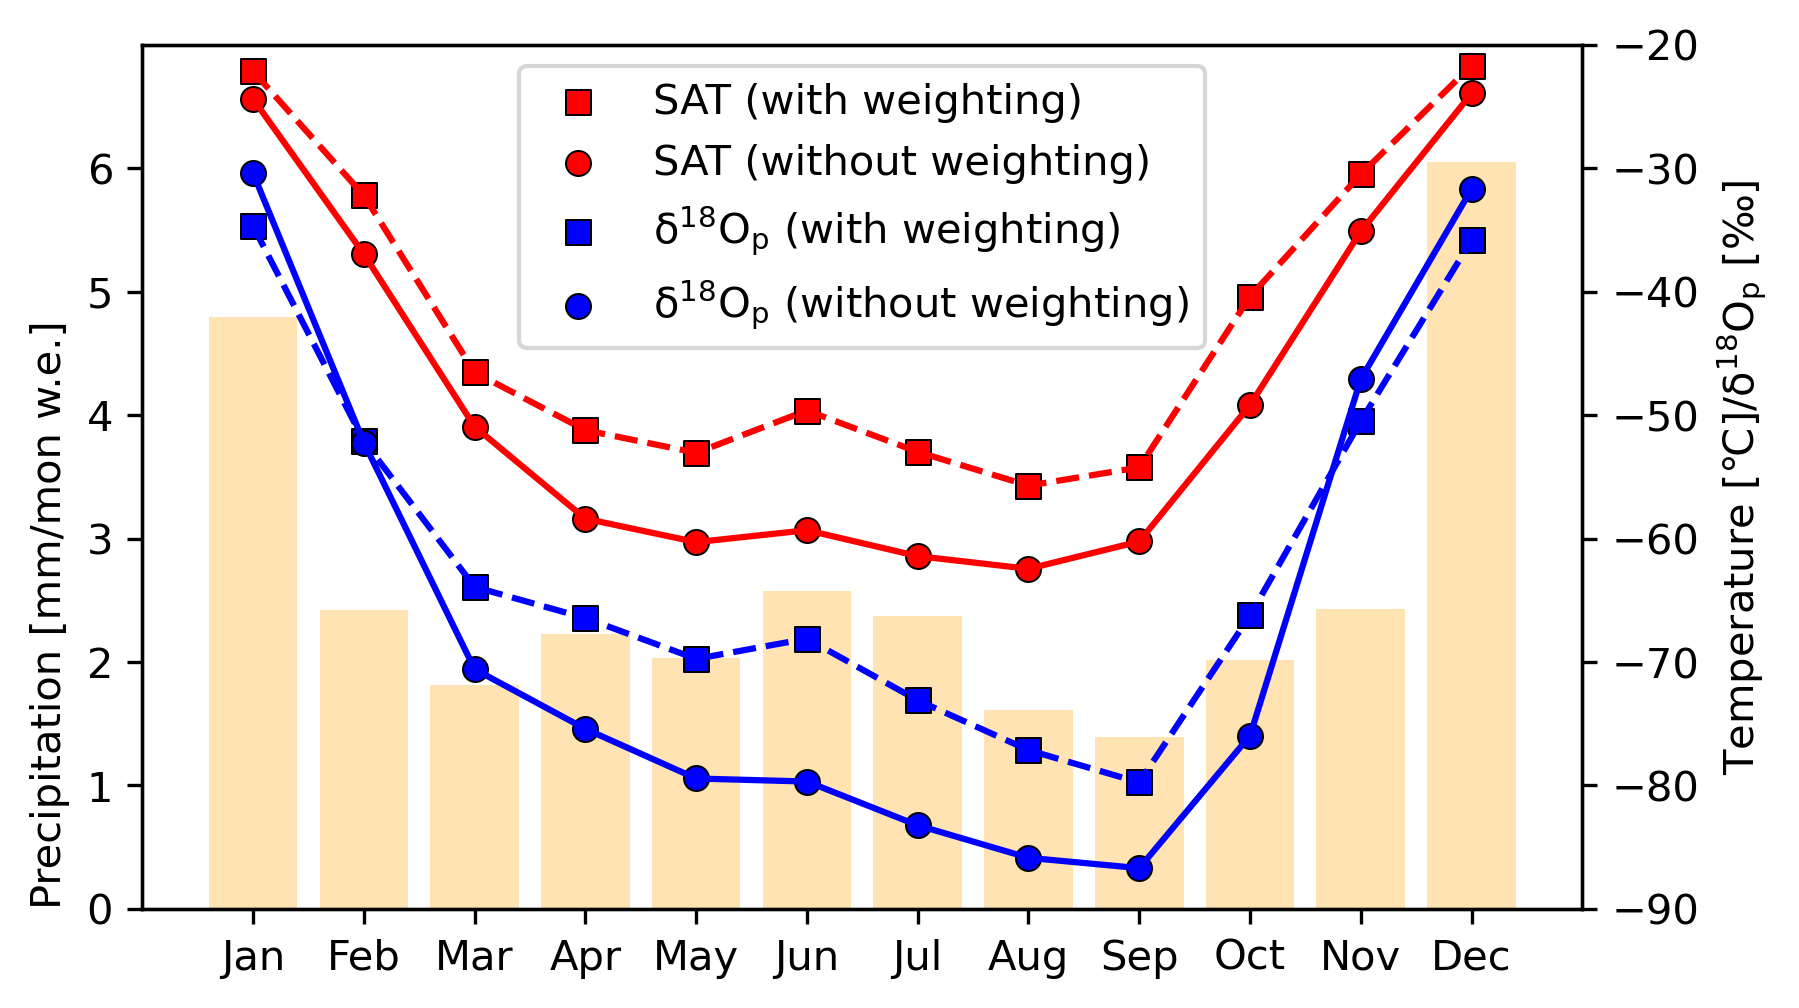

In [14]:
fig = plt.figure(figsize=(6,4)) 

ax = plt.subplot2grid((1,4),(0,0), colspan=4)
ax.bar(df["Mon"],df["prcp"],alpha=0.3, color="orange")
ax.set_ylabel("Precipitation [mm/mon w.e.]", loc="bottom")
ax.set_ylim((0,7))
ax.set_yticks(np.arange(0,7,1))
ax.set_yticklabels(np.arange(0,7,1))
ax.set_xlabel("")
plt.xticks(np.arange(1,13,1),(mons[""][:12]))
ax2=ax.twinx()
sns.set_palette("Set1")
sns.lineplot(data=df, x="Mon", y="tempw",color="red",linestyle="dashed")
sns.lineplot(data=df, x="Mon", y="temp",color="red")
sns.lineplot(data=df, x="Mon", y="d18Opw",color="blue",linestyle="dashed")
sns.lineplot(data=df, x="Mon", y="d18Op",color="blue")
sns.set_palette("Set1")
sns.scatterplot(data=df, x="Mon", y="tempw",  label="SAT (with weighting)",edgecolor="black",color="red",marker="s")
sns.scatterplot(data=df, x="Mon", y="temp",  label="SAT (without weighting)",edgecolor="black",color="red")
sns.scatterplot(data=df, x="Mon", y="d18Opw", label="$\mathsf{\delta ^{18}O_{p}}$ (with weighting)",edgecolor="black",color="blue",marker="s")
sns.scatterplot(data=df, x="Mon", y="d18Op",label="$\mathsf{\delta ^{18}O_p}$ (without weighting)",edgecolor="black",color="blue")
ax2.set_ylabel("")
ax2.set_xlim((0,13))
ax2.legend(loc="upper center")
ax2.set_ylim((-90,-20))
ax2.yaxis.set_label_position("right")
ax2.set_ylabel("Temperature [℃]/$\mathsf{\delta ^{18}O_p}$ [\u2030]")


plt.subplots_adjust(top=0.92,bottom=0.2,left=0.1,right=0.9,hspace=0.05,wspace=0.05)
plt.show()
fig.savefig("monthly_reconst.png")
fig.savefig("pic/FigureS5.jpg")

Kanon Kino (kanon[at]aori.u-tokyo.ac.jp)